<a href="https://colab.research.google.com/github/aritrasen87/LLM_RAG_Model_Deployment/blob/main/LangGraph_AgentSwarm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

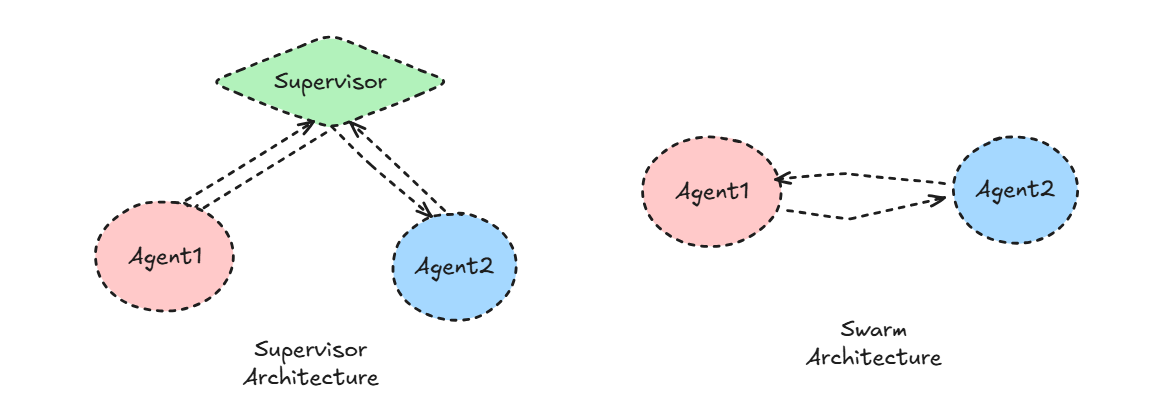

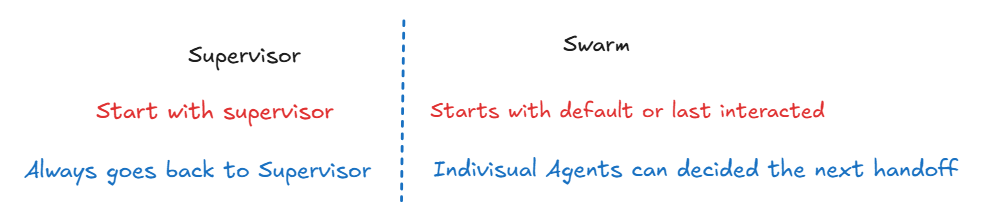

### Installations

In [1]:
! pip install langchain -q
! pip install langgraph_swarm --q
! pip install langchain_openai langchain_community langchain_experimental --q
! pip install sentence-transformers -q
! pip install datasets chromadb -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.9/130.9 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.3/55.3 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 69.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/21

### Credentials

In [2]:
from google.colab import userdata
import os
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_KEY')
os.environ['TAVILY_API_KEY'] = userdata.get('TAVILY')

### LLM Initialization

In [3]:
from langchain_openai import ChatOpenAI
model = ChatOpenAI(model="gpt-4o")

### Imports:
1. create_react_agent
2. create_handoff_tool, create_swarm

In [4]:
from langgraph.prebuilt import create_react_agent

from langgraph_swarm import create_handoff_tool, create_swarm

### Tools Creation - WebSearch

In [5]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_tool = TavilySearchResults(max_results=5)

In [6]:
def web_search(query: str) -> str:
    """Search the web for information."""
    docs = tavily_tool.invoke({"query": query})
    web_results = "\n".join([d["content"] for d in docs])
    return web_results

### Tools Creation - RAGSearch

In [7]:
import datasets
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain.docstore.document import Document


knowledge_base = datasets.load_dataset("m-ric/huggingface_doc", split="train")
knowledge_base = knowledge_base.filter(lambda row: row["source"].startswith("huggingface/transformers"))

source_docs = [
    Document(page_content=doc["text"], metadata={"source": doc["source"].split("/")[1]})
    for doc in knowledge_base
]

### Creating Chunks using RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=50,
    add_start_index=True,
    strip_whitespace=True,
    separators=["\n\n", "\n", ".", " ", ""],
)
new_docs = text_splitter.split_documents(documents=source_docs)

###  BGE Embddings

from langchain_community.embeddings import HuggingFaceBgeEmbeddings

model_name = "BAAI/bge-small-en"
model_kwargs = {"device": "cuda"}
encode_kwargs = {"normalize_embeddings": True}
embeddings = HuggingFaceBgeEmbeddings(
    model_name=model_name, model_kwargs=model_kwargs, encode_kwargs=encode_kwargs
)
### Populate Vector DB

db = Chroma.from_documents(new_docs, embeddings)

README.md:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

huggingface_doc.csv:   0%|          | 0.00/22.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2647 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2647 [00:00<?, ? examples/s]

<ipython-input-7-a6728d74d509>:33: LangChainDeprecationWarning: The class `HuggingFaceBgeEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceBgeEmbeddings(
The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/90.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [8]:
def rag_search(query:str):
    "Function to do RAG search"
    retriever = db.as_retriever(search_kwargs={"k": 4})
    docs = retriever.invoke(
            query,
        )
    return "\nRetrieved documents:\n" + "".join(
        [
            f"\n\n===== Document {str(i)} =====\n" + doc.page_content
            for i, doc in enumerate(docs)
        ]
    )

### Define handoff tools

In [9]:
transfer_to_rag_assistant = create_handoff_tool(
    agent_name="rag_assistant",
    description="Transfer user to the rag-search when questions are related to Transformers",
)
transfer_to_research_assistant = create_handoff_tool(
    agent_name="research_assistant",
    description="Transfer user to the research_assistant when questions are related to recent happening in the world",
)

### Agents Creation

1. research_assistant with transfer_to_rag_assistant handoff
2. rag_assistant with transfer_to_research_assistant handoff

In [12]:
research_assistant = create_react_agent(
    model=model,
    tools=[web_search,transfer_to_rag_assistant],
    name="research_assistant",
    prompt="You are a world class researcher with access to web search."
)

rag_assistant = create_react_agent(
    model=model,
    tools=[rag_search,transfer_to_research_assistant],
    name="rag_assistant",
    prompt="You are a RAG tool with access to transformer related documents."
)

### Swarm Agents Creation

In [13]:
builder = create_swarm([research_assistant, rag_assistant], default_active_agent="research_assistant")

In [15]:
app = builder.compile()

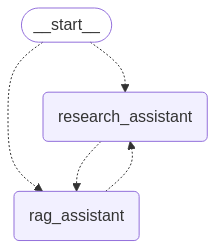

In [16]:
from IPython.display import Image

display(Image(app.get_graph().draw_mermaid_png()))

### Testing the Agent

In [17]:
result = app.invoke({
    "messages": [
        {
            "role": "user",
            "content": "Tell me the about India's GDP from past 5 years."
        }
    ]
})

In [18]:
for m in result['messages']:
    m.pretty_print()

================================ Human Message =================================

Tell me the about India's GDP from past 5 years.
================================== Ai Message ==================================
Name: research_assistant
Tool Calls:
  web_search (call_tTgge063Bc6Ya0o9rfpWpxZ8)
 Call ID: call_tTgge063Bc6Ya0o9rfpWpxZ8
  Args:
    query: India GDP last 5 years
================================= Tool Message =================================
Name: web_search

| 2023 | $3,549.92B | $2,485 | 7.58% | | 2022 | $3,353.47B | $2,366 | 6.99% | | 2021 | $3,167.27B | $2,250 | 9.69% | | 2020 | $2,674.85B | $1,916 | -5.78% | | 2019 | $2,835.61B | $2,050 | 3.87% | | 2018 | $2,702.93B | $1,974 | 6.45% | | 2017 | $2,651.47B | $1,958 | 6.80% | | 2016 | $2,294.80B | $1,714 | 8.26% | | 2015 | $2,103.59B | $1,590 | 8.00% | | 2014 | $2,039.13B | $1,560 | 7.41% | | 2013 | $1,856.72B | $1,438 | 6.39% | | 2012 | $1,827.64B | $1,434 | 5.46% | | 2011 | $1,823.05B | $1,450 | 5.24% |
India GDP Growth 

In [20]:
result = app.invoke({
    "messages": [
        {
            "role": "user",
            "content": "Tell me the role of Q,K,V matrixes in transfromer archietecture."
        }
    ]
})

In [21]:
for m in result['messages']:
    m.pretty_print()

================================ Human Message =================================

Tell me the role of Q,K,V matrixes in transfromer archietecture.
================================== Ai Message ==================================
Name: research_assistant
Tool Calls:
  transfer_to_rag_assistant (call_fy9YwTjr2SrEueUoHio3XnLV)
 Call ID: call_fy9YwTjr2SrEueUoHio3XnLV
  Args:
================================= Tool Message =================================
Name: transfer_to_rag_assistant

Successfully transferred to rag_assistant
================================== Ai Message ==================================
Name: rag_assistant

In the transformer architecture, the matrices Q (Query), K (Key), and V (Value) play crucial roles in the attention mechanism, which is a core component of the model. Here's how they function:

1. **Query (Q) Matrix**: 
   - The Query matrix is used to express the active interest or need for information of the input sequence at each position.
   - It represents the s